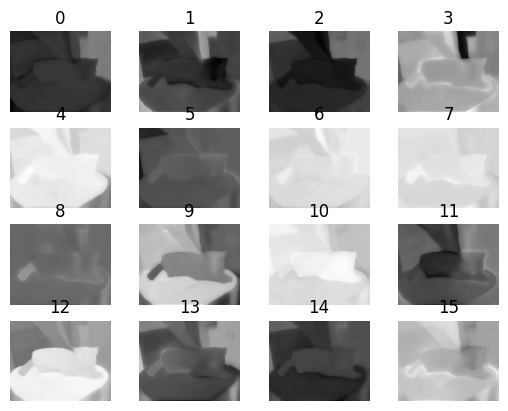

In [20]:
import numpy as np
import matplotlib.pyplot as plt

feats = np.load('feats.npy')
F, H, W = feats.shape
# feats is F, H, W
sqrtF = int(np.ceil(np.sqrt(F)))
for f in range(F):
    plt.subplot(sqrtF, sqrtF, f+1)
    plt.imshow(feats[f], cmap='gray')
    plt.axis('off')
    plt.title(f)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 499.5, 399.5, -0.5)

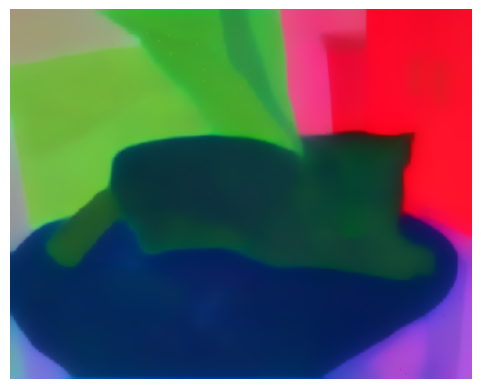

In [21]:
# we will PCA them to 3d and show the image
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
rgbfeats = pca.fit_transform(feats.reshape(F, H*W).T)
rgbfeats = rgbfeats.reshape(H, W, 3)

minmaxnorm = lambda x: (x - x.min()) / (x.max() - x.min())
def pct_norm(x, pct=1):
    return (x - np.percentile(x,pct)) / (np.percentile(x, 100-pct) - np.percentile(x, pct))
plt.imshow(pct_norm(rgbfeats))
plt.axis('off')


(-0.5, 499.5, 399.5, -0.5)

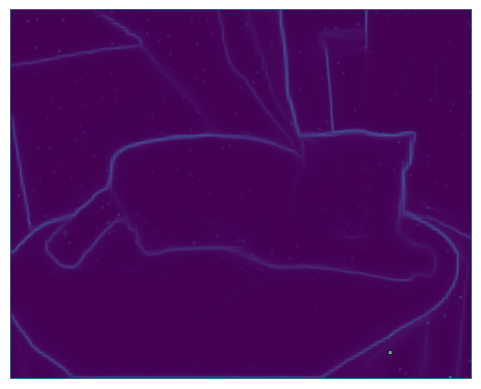

In [22]:
# we can also show the borders
import torch
def get_gradients(pred):
    F, H, W = pred[0].shape
    sobel_x = (
        torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).float().to(pred.device)
    )
    sobel_y = sobel_x.T
    sobel_x = sobel_x.repeat(F, 1, 1, 1)
    sobel_y = sobel_y.repeat(F, 1, 1, 1)
    edge_x = torch.nn.functional.conv2d(pred, sobel_x, padding=1, groups=F).view(
        F, H, W
    )  # 1, F, H, W
    edge_y = torch.nn.functional.conv2d(pred, sobel_y, padding=1, groups=F).view(
        F, H, W
    )
    edge_x = torch.norm(edge_x, dim=0, p=2)  # will take sqrt
    edge_y = torch.norm(edge_y, dim=0, p=2)  # H, W
    return edge_x, edge_y

def sobel_from_pred(pred):
    edge_x, edge_y = get_gradients(pred)
    edge = torch.sqrt(edge_x**2 + edge_y**2)
    return edge

edge = sobel_from_pred(torch.from_numpy(feats[None]))
plt.imshow(edge.numpy())
plt.axis('off')
